In [ ]:
pip install -q langchain_openai langgraph langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.1/489.1 kB 10.4 MB/s eta 0:00:00


In [ ]:
import sqlite3

conn = sqlite3.connect("shop.db", check_same_thread = False)

In [ ]:
# Create users table
conn.execute('''
CREATE TABLE IF NOT EXISTS users (
    id INTEGER PRIMARY KEY,
    name TEXT,
    email TEXT,
    signup_date DATE
)
''')

# Create orders table
conn.execute('''
CREATE TABLE IF NOT EXISTS orders (
    id INTEGER PRIMARY KEY,
    user_id INTEGER,
    amount REAL,
    status TEXT,
    order_date DATE,
    FOREIGN KEY(user_id) REFERENCES users(id)
)
''')

# Insert users
conn.execute("INSERT INTO users VALUES (1, 'Alice', 'alice@example.com', '2024-01-10')")
conn.execute("INSERT INTO users VALUES (2, 'Bob', 'bob@example.com', '2024-03-15')")
conn.execute("INSERT INTO users VALUES (3, 'Charlie', 'charlie@example.com', '2024-03-22')")
conn.execute("INSERT INTO users VALUES (4, 'Diana', 'diana@example.com', '2024-04-05')")
conn.execute("INSERT INTO users VALUES (5, 'Eve', 'eve@example.com', '2024-04-25')")
conn.execute("INSERT INTO users VALUES (6, 'Frank', 'frank@example.com', '2024-05-15')")
conn.execute("INSERT INTO users VALUES (7, 'Grace', 'grace@example.com', '2024-05-18')")
conn.execute("INSERT INTO users VALUES (8, 'Henry', 'henry@example.com', '2024-05-20')")
conn.execute("INSERT INTO users VALUES (9, 'Ivy', 'ivy@example.com', '2024-06-01')")
conn.execute("INSERT INTO users VALUES (10, 'Jack', 'jack@example.com', '2024-06-05')")
conn.execute("INSERT INTO users VALUES (11, 'Kiran', 'kiran@example.com', '2024-06-03')")
conn.execute("INSERT INTO users VALUES (12, 'Lata', 'lata@example.com', '2024-06-04')")
conn.execute("INSERT INTO users VALUES (13, 'Manoj', 'manoj@example.com', '2024-06-06')")

# Insert orders
conn.execute("INSERT INTO orders VALUES (1, 1, 250.00, 'completed', '2024-03-10')")
conn.execute("INSERT INTO orders VALUES (2, 2, 100.00, 'pending', '2024-03-16')")
conn.execute("INSERT INTO orders VALUES (3, 3, 320.00, 'completed', '2024-03-24')")
conn.execute("INSERT INTO orders VALUES (4, 4, 180.00, 'completed', '2024-05-01')")
conn.execute("INSERT INTO orders VALUES (5, 5, 210.00, 'completed', '2024-05-02')")
conn.execute("INSERT INTO orders VALUES (6, 1, 180.00, 'completed', '2024-03-18')")
conn.execute("INSERT INTO orders VALUES (7, 2, 120.00, 'completed', '2024-03-20')")
conn.execute("INSERT INTO orders VALUES (8, 1, 300.00, 'completed', '2024-04-01')")
conn.execute("INSERT INTO orders VALUES (9, 3, 80.00, 'cancelled', '2024-04-10')")
conn.execute("INSERT INTO orders VALUES (10, 4, 250.00, 'pending', '2024-05-05')")
conn.execute("INSERT INTO orders VALUES (11, 6, 400.00, 'completed', '2024-05-20')")
conn.execute("INSERT INTO orders VALUES (12, 7, 320.00, 'completed', '2024-05-22')")
conn.execute("INSERT INTO orders VALUES (13, 8, 150.00, 'pending', '2024-05-25')")
conn.execute("INSERT INTO orders VALUES (14, 9, 220.00, 'completed', '2024-06-02')")
conn.execute("INSERT INTO orders VALUES (15, 10, 500.00, 'completed', '2024-06-06')")



In [ ]:
conn.commit()

In [ ]:
from langchain_core.tools import tool


@tool
def get_schema() -> str:
  """Returns table schemas from the SQLite database"""
  schema = ""
  for table in ["users", "orders"]:
    rows = conn.execute(f"PRAGMA table_info({table})").fetchall()
    cols = ",".join([f"{r[1]} {r[2]}" for r in rows])
    schema += f"{table}({cols})\n"
  return schema.strip()

@tool
def execute_sql(query: str) -> str:
  """Executes SQL query on the database and return the result"""
  try:
    result = conn.execute(query).fetchall()
    return str(result)
  except Exception as e:
    return f"Error: {str(e)}"






In [ ]:
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode, create_react_agent
from langchain_openai import ChatOpenAI
from typing import Annotated, TypedDict
from langgraph.prebuilt import tools_condition
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage

import os

os.environ["OPENAI_API_KEY"] = ""

llm = ChatOpenAI(model="gpt-4o-mini")


In [ ]:
#analyst agent

analyst_llm = llm.bind_tools([get_schema])

analyst_system_message = [SystemMessage(content="""You are a data analyst. Start by understanding the database schema using tools.
    Then ask at least 10 insightful questions in a single response that will help in creating a comprehensive report.
    """)]

class AnalystState(TypedDict):
  messages: Annotated[list[AnyMessage], add_messages]

def analyst(state: AnalystState) -> AnalystState:
  response = analyst_llm.invoke(analyst_system_message + state["messages"])
  return {"messages": [response]}


analyst_graph = StateGraph(AnalystState)
analyst_graph.add_node("analyst", analyst)
analyst_graph.add_node("tools", ToolNode([get_schema]))

analyst_graph.add_edge(START, "analyst")
analyst_graph.add_conditional_edges("analyst", tools_condition)
analyst_graph.add_edge("tools","analyst")

analyst_app = analyst_graph.compile()

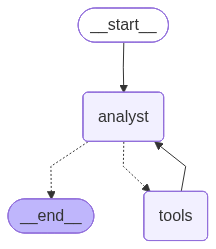

In [ ]:
from IPython.display import Image, display

display(Image(analyst_app.get_graph().draw_mermaid_png()))

In [ ]:
result = analyst_app.invoke({"messages": [HumanMessage("")]})
print(result["messages"][-1].content)

The database schema consists of two tables:

1. **users**
   - `id` (INTEGER): Unique identifier for each user.
   - `name` (TEXT): Name of the user.
   - `email` (TEXT): Email address of the user.
   - `signup_date` (DATE): Date when the user signed up.

2. **orders**
   - `id` (INTEGER): Unique identifier for each order.
   - `user_id` (INTEGER): Foreign key linking to the `users` table.
   - `amount` (REAL): Total amount of the order.
   - `status` (TEXT): Current status of the order (e.g., completed, pending, canceled).
   - `order_date` (DATE): Date when the order was placed.

Based on this schema, here are ten insightful questions that could help in creating a comprehensive report:

1. What is the total number of users currently in the database?
2. How many users signed up in the last month/quarter/year?
3. What is the average order amount for all users?
4. How many orders has each user placed on average?
5. What percentage of orders are completed versus pending or canceled?
6. W

In [ ]:
#expert agent

expert_llm = llm.bind_tools([get_schema, execute_sql])

expert_system_message = [SystemMessage(content="""You are a data expert.
Use tools to answer the analyst's questions by querying the database.
you do not have to summarize it. Later reviwer will do that.""")]

class ExpertState(TypedDict):
  messages: Annotated[list[AnyMessage], add_messages]

def expert(state: ExpertState) -> ExpertState:
  response = expert_llm.invoke(expert_system_message + state["messages"])
  return {"messages": [response]}


expert_graph = StateGraph(ExpertState)
expert_graph.add_node("expert", expert)
expert_graph.add_node("tools", ToolNode([get_schema, execute_sql]))

expert_graph.add_edge(START, "expert")
expert_graph.add_conditional_edges("expert", tools_condition)
expert_graph.add_edge("tools","expert")

expert_app = expert_graph.compile()

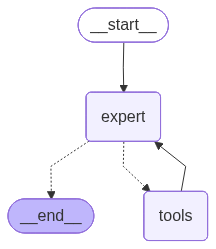

In [ ]:
from IPython.display import Image, display

display(Image(expert_app.get_graph().draw_mermaid_png()))

In [ ]:
pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=333ec6b7a271787f61a837890d46fab8123dfc233cd5d1078d74e04fc6961cc6
  Stored in directory: /root/.cache/pip/wheels/6e/62/11/dc73d78e40a218ad52e7451f30166e94491be013a7850b5d75
Successfully built fpdf


In [ ]:
from langchain.tools import tool

@tool
def generate_pdf_report(text: str, filename: str = "my_report.pdf") -> str:
    """
    Converts the provided text summary into a downloadable PDF report.
    Returns the file path.
    """
    from fpdf import FPDF
    import os

    try:
        pdf = FPDF()
        pdf.add_page()
        pdf.set_auto_page_break(auto=True, margin=15)
        pdf.set_font("Arial", size=12)

        for line in text.split("\n"):
            pdf.multi_cell(0, 10, line)

        # Save the file
        file_path = f"/content/sample_data/{filename}"
        pdf.output(file_path)
        return file_path
    except Exception as e:
        return f"PDF generation failed: {str(e)}"


In [ ]:
#reviwer agent

reviewer_llm = llm.bind_tools([generate_pdf_report])

reviewer_system_message = [SystemMessage(content="""You are an expert reviewer tasked with summarizing detailed database analysis reports.
Your goal is to produce a concise and clear summary in exactly eight lines.
Focus on key insights such as user count and growth, order statistics, top performers, and actionable recommendations.
Avoid repeating detailed tables or lists; instead, synthesize the information to highlight the main takeaways.
Keep the language simple and professional.
Make sure the summary is polished, easy to understand, and ready for presentation as a PDF document.
Give 2 actionable insights at the end to conclude
""")]

class ReviewerState(TypedDict):
  messages: Annotated[list[AnyMessage], add_messages]

def reviewer(state: ReviewerState) -> ReviewerState:
  response = reviewer_llm.invoke(reviewer_system_message + state["messages"])
  return {"messages": [response]}


reviewer_graph = StateGraph(ReviewerState)
reviewer_graph.add_node("reviewer", reviewer)
reviewer_graph.add_node("tools", ToolNode([generate_pdf_report]))

reviewer_graph.add_edge(START, "reviewer")
reviewer_graph.add_conditional_edges("reviewer", tools_condition)
reviewer_graph.add_edge("tools","reviewer")

reviewer_app = reviewer_graph.compile()

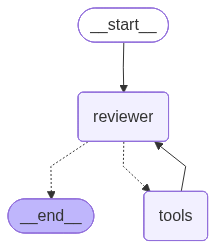

In [ ]:
from IPython.display import Image, display

display(Image(reviewer_app.get_graph().draw_mermaid_png()))

In [ ]:
# define the supervisor

from pydantic import BaseModel, Field
from typing import Literal

class AgentSelector(BaseModel):
  """Route to the available agent if needed, else route to END"""
  next_node: Literal["analyst","expert","reviewer","END"] = Field(
      description = "Route to the available agent if needed, else route to END"
  )

llm = ChatOpenAI(model="gpt-4o-mini")
agent_selector_llm = llm.with_structured_output(AgentSelector)

supervisor_system_message = [SystemMessage(content="""
You are a supervisor agent in charge of orchestrating three roles: [analyst, expert, and reviewer].

1. The **analyst** explores the database schema and raises insightful questions.
2. The **expert** answers these questions using SQL tools on the database.
3. The **reviewer** summarizes the expert’s answers into a polished report.

At each step:
- Set the 'next_node' to one of: 'analyst', 'expert', 'reviewer', or 'END'.
- First, route to the analyst to begin exploration.
- Once enough questions are asked, route to the expert to answer them.
- After answering, route to the reviewer to summarize everything.
- Finally, route to 'END' when the process is complete.

It is mandatory to go to each of the node atleast once.

Do not perform the tasks yourself. Your job is only to **coordinate** and **decide** the next best agent to handle the task.
""")]




In [ ]:
class SupervisorState(TypedDict):
  messages: Annotated[list[AnyMessage], add_messages]
  next_node: Literal["analyst","expert","reviewer","END"]

def supervisor(state: SupervisorState) -> SupervisorState:
  response = agent_selector_llm.invoke(supervisor_system_message + state["messages"])
  return {"messages":[AIMessage(content=f"Routing to: {response.next_node}" )],
          "next_node": response.next_node
          }

In [ ]:
def route_from_supervisor(state: SupervisorState) -> Literal["analyst","expert","reviewer","__end__"]:
  """
  Route based on the supervisors decision.
  It reads the next_node key from the supervisor state.
  """
  next_node = state.get("next_node")
  if next_node == "END":
    return "__end__"
  else:
    return next_node

In [ ]:
graph = StateGraph(SupervisorState)
graph.add_node("supervisor", supervisor)
graph.add_node("analyst", analyst_app)
graph.add_node("expert", expert_app)
graph.add_node("reviewer", reviewer_app)

graph.add_edge(START, "supervisor")
graph.add_conditional_edges("supervisor", route_from_supervisor)
graph.add_edge("analyst","supervisor")
graph.add_edge("expert","supervisor")
graph.add_edge("reviewer","supervisor")

final_app = graph.compile()

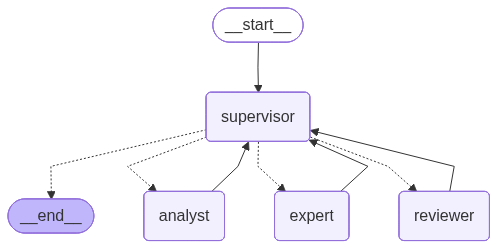

In [ ]:
from IPython.display import Image, display

display(Image(final_app.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage

inputs = {
    "messages": [
        HumanMessage(content="Generate a summary report based on tables in my database.")
    ]
}

for output in final_app.stream(inputs):
    for key, value in output.items():
        print("=" * 50)
        print(f"📍 Node: {key}")
        print("-" * 50)
        for msg in value["messages"]:
            print(f"{msg.type.upper()}: {msg.content}\n")
        print("=" * 50)

📍 Node: supervisor
--------------------------------------------------
AI: Routing to: analyst

📍 Node: analyst
--------------------------------------------------
HUMAN: Generate a summary report based on tables in my database.

AI: Routing to: analyst

AI: 

TOOL: users(id INTEGER,name TEXT,email TEXT,signup_date DATE)
orders(id INTEGER,user_id INTEGER,amount REAL,status TEXT,order_date DATE)

AI: Based on the database schema, there are two tables:

1. **Users Table**:
   - **id**: Unique identifier for each user (INTEGER)
   - **name**: Name of the user (TEXT)
   - **email**: Email address of the user (TEXT)
   - **signup_date**: Date the user signed up (DATE)

2. **Orders Table**:
   - **id**: Unique identifier for each order (INTEGER)
   - **user_id**: Foreign key linking to the user who made the order (INTEGER)
   - **amount**: Amount of the order (REAL)
   - **status**: Status of the order (TEXT)
   - **order_date**: Date the order was placed (DATE)

### Insightful Questions for a